In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import random

In [2]:
left_eye_dataset = pd.read_csv('./retinopathy_dataset/trian_left_eye.csv')
left_eye_dataset.head()

,patient_id,image_id,image_path,left_eye_DR_Level
0,1,1_l1,\regular-fundus-training\1\1_l1.jpg,0
1,1,1_l2,\regular-fundus-training\1\1_l2.jpg,0
2,2,2_l1,\regular-fundus-training\2\2_l1.jpg,2
3,2,2_l2,\regular-fundus-training\2\2_l2.jpg,2
4,3,3_l1,\regular-fundus-training\3\3_l1.jpg,1


In [3]:
DIRECTORY = r'D:\jupyter\retinopathy_dataset\DeepDRiD\regular_fundus_images'
img_path = left_eye_dataset['image_path']

for i in range(len(img_path)):
    img_path[i] = (img_path[i][:24]+'\\'+'Images'+'\\'+img_path[i][25:])

<ipython-input-3-e02fa999d374>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_path[i] = (img_path[i][:24]+'\\'+'Images'+'\\'+img_path[i][25:])


In [4]:
def image_preprocessing(img,img_size):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , 45) ,-4 ,128)
    img = cv2.resize(img,(img_size,img_size))
    
    return img

In [6]:
def image_show(img_path,level):
    img_size = 256

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.xlabel("img before preprocessing - "+str(level))

    img = image_preprocessing(img,img_size)
    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.xlabel("img after preprocessing - "+str(level))

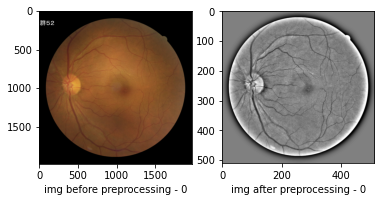

In [7]:
img_path = DIRECTORY+left_eye_dataset['image_path'][33]
image_show(img_path,0)

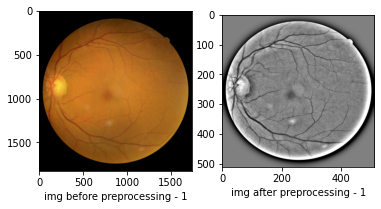

In [8]:
img_path = DIRECTORY+left_eye_dataset['image_path'][107]
image_show(img_path,1)

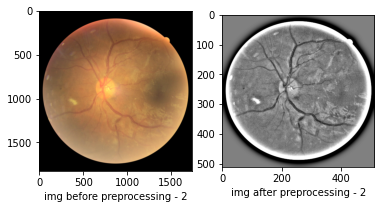

In [9]:
img_path = DIRECTORY+left_eye_dataset['image_path'][104]
image_show(img_path,2)

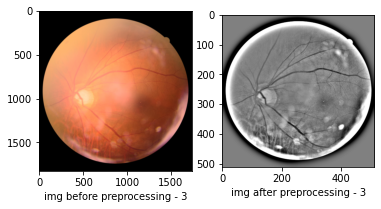

In [10]:
img_path = DIRECTORY+left_eye_dataset['image_path'][562]
image_show(img_path,3)

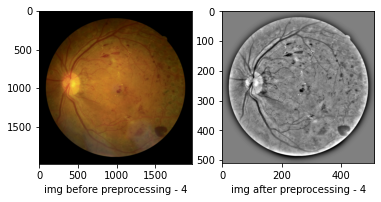

In [11]:
img_path = DIRECTORY+left_eye_dataset['image_path'][471]
image_show(img_path,4)

In [5]:
data = []
img_size = 256
for i in range(len(left_eye_dataset['image_path'])):
    img_path = DIRECTORY+left_eye_dataset['image_path'][i]
    img = cv2.imread(img_path)
    img = image_preprocessing(img,img_size)
    data.append([img, left_eye_dataset['left_eye_DR_Level'][i]])

In [6]:
pickle.dump(data,open("left_retina_dataset",'wb'))

In [8]:
data = pickle.load(open("left_retina_dataset",'rb'))

In [9]:
data

[[array([[[128, 128, 128],
          [128, 128, 128],
          [128, 128, 128],
          ...,
          [128, 128, 128],
          [128, 128, 128],
          [128, 128, 128]],
  
         [[128, 128, 128],
          [128, 128, 128],
          [128, 128, 128],
          ...,
          [128, 128, 128],
          [128, 128, 128],
          [128, 128, 128]],
  
         [[128, 128, 128],
          [128, 128, 128],
          [128, 128, 128],
          ...,
          [128, 128, 128],
          [128, 128, 128],
          [128, 128, 128]],
  
         ...,
  
         [[128, 128, 128],
          [128, 128, 128],
          [128, 128, 128],
          ...,
          [128, 128, 128],
          [128, 128, 128],
          [128, 128, 128]],
  
         [[128, 128, 128],
          [128, 128, 128],
          [128, 128, 128],
          ...,
          [128, 128, 128],
          [128, 128, 128],
          [128, 128, 128]],
  
         [[128, 128, 128],
          [128, 128, 128],
          [128, 128, 128

In [7]:
random.shuffle(data)

X=[]
Y=[]

for features,labels in data:
    X.append(features)
    Y.append(labels)
    
X=np.array(X)
Y=np.array(Y)

X=X/255

In [15]:
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras import backend as K
import keras
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D

In [16]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(512,512,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(5, activation='softmax', name='output'))
    return model

In [17]:
model=VGG16()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 256)     2

In [19]:
Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)

In [20]:
for layer in Vgg16.layers:
    layer.trainable = False

In [21]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(X,Y,epochs=30,validation_split=0.3,verbose=1)

Epoch 1/30
